In [4]:
train_dir = 'D:/Documentos/Estudio/Maestría/1-Periodo/Aprendizaje_Computacional/Modelopropio/Database/Lung Segmentation Data/Lung Segmentation Data/Train' 
val_dir = 'D:/Documentos/Estudio/Maestría/1-Periodo/Aprendizaje_Computacional/Modelopropio/Database/Lung Segmentation Data/Lung Segmentation Data/Val' 
test_dir = 'D:/Documentos/Estudio/Maestría/1-Periodo/Aprendizaje_Computacional/Modelopropio/Database/Lung Segmentation Data/Lung Segmentation Data/Test'

In [2]:
#ELEGIMOS LOS PARAMETROS
from keras.preprocessing.image import ImageDataGenerator
ih, iw = 224, 224 #tamano de la imagen
input_shape = (ih, iw, 3) #forma de la imagen: alto ancho y numero de canales

num_class = 2 #cuantas clases 
#epochs = 15 #cuantas veces entrenar. En cada epoch hace una mejora en los parametros

batch_size = 32 #batch para hacer cada entrenamiento. Lee 50 'batch_size' imagenes antes de actualizar los parametros. Las carga a memoria
num_train = 21715 #numero de imagenes en train
num_test = 6788 #numero de imagenes en test
num_val=5417

epoch_steps = num_train // batch_size 
test_steps = num_test // batch_size
 

Using TensorFlow backend.


In [5]:
#LEEMOS LAS IMÁGENES 

img_height, img_width=ih, iw

train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical') # set as training data

validation_generator = train_datagen.flow_from_directory(
    val_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical') # set as validation data

test_generator = train_datagen.flow_from_directory(
    test_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical') # set as validation data

Found 14507 images belonging to 2 classes.
Found 3615 images belonging to 2 classes.
Found 4535 images belonging to 2 classes.


In [6]:
train=train_generator
val=validation_generator
test=test_generator

In [12]:
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2

Xception_model = Xception(include_top=False, weights='imagenet',  
                                     input_shape=input_shape) 

Xception_model.trainable=False

In [13]:
import pandas as pd 
pd.set_option('max_colwidth', -1)

layers = [(layer, layer.name, layer.trainable) for layer in Xception_model.layers] 
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

C:\Users\elium\.conda\envs\tfGPU\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x00000249E74ED1C8>,input_2,False
1,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000249E74ED308>,block1_conv1,False
2,<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x00000249E74F2548>,block1_conv1_bn,False
3,<tensorflow.python.keras.layers.core.Activation object at 0x00000249E74F2608>,block1_conv1_act,False
4,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000249E74F2D08>,block1_conv2,False
...,...,...,...
127,<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x00000249E9313A48>,block14_sepconv1_bn,False
128,<tensorflow.python.keras.layers.core.Activation object at 0x00000249E93176C8>,block14_sepconv1_act,False
129,<tensorflow.python.keras.layers.convolutional.SeparableConv2D object at 0x00000249E9317688>,block14_sepconv2,False
130,<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x00000249E936EBC8>,block14_sepconv2_bn,False


In [14]:
print(Xception_model.summary())

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [15]:
from keras import backend as K
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [16]:

from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.utils import to_categorical 
from keras import optimizers 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, BatchNormalization
# build model architecture 
model = Sequential()
model.add(Xception_model)
model.add(Flatten())
#model.add(Dense(256, activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(num_class, activation='softmax'))
#compile model
model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.001, momentum=0.9), 
      loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True), 
      metrics=['accuracy',f1_m,precision_m, recall_m])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 7, 7, 2048)        20861480  
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 200706    
Total params: 21,062,186
Trainable params: 200,706
Non-trainable params: 20,861,480
_________________________________________________________________
None


In [17]:
history = model.fit_generator(train, 
                              epochs=10,  
                              validation_data=val, 
                              verbose=1)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 454 steps, validate for 113 steps
Epoch 1/10
454/454 [==============================] - 64s 141ms/step - loss: 0.4473 - accuracy: 0.8685 - f1_m: 0.8687 - precision_m: 0.8687 - recall_m: 0.8687 - val_loss: 0.7929 - val_accuracy: 0.4965 - val_f1_m: 0.4965 - val_precision_m: 0.4965 - val_recall_m: 0.4965
Epoch 2/10
454/454 [==============================] - 59s 129ms/step - loss: 0.4022 - accuracy: 0.9169 - f1_m: 0.9170 - precision_m: 0.9170 - recall_m: 0.9170 - val_loss: 0.7378 - val_accuracy: 0.5430 - val_f1_m: 0.5430 - val_precision_m: 0.5430 - val_recall_m: 0.5430
Epoch 3/10
454/454 [==============================] - 59s 131ms/step - loss: 0.3867 - accuracy: 0.9345 - f1_m: 0.9346 - precision_m: 0.9346 - recall_m: 0.9346 - val_loss: 0.7636 - val_accuracy: 0.5201 - val_f1_m: 0.5201 - val_precision_m: 0.5201 - val_recall_m: 0.5201
Epoch 4/10
454/454 [===

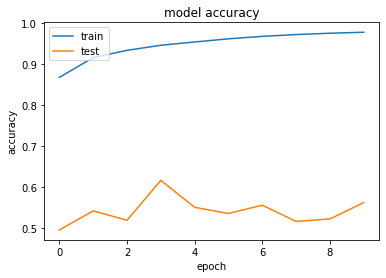

In [18]:
# summarize history for accuracy
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

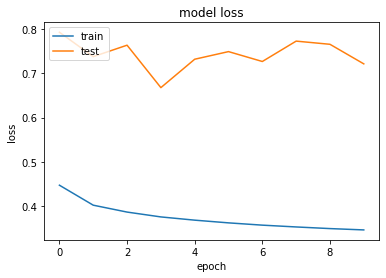

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

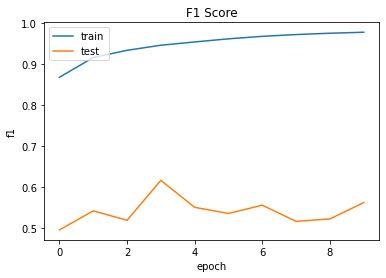

In [20]:
plt.plot(history.history['f1_m'])
plt.plot(history.history['val_f1_m'])
plt.title('F1 Score')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

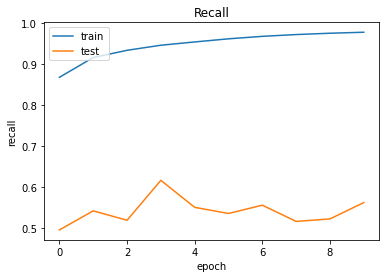

In [21]:
plt.plot(history.history['recall_m'])
plt.plot(history.history['val_recall_m'])
plt.title('Recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

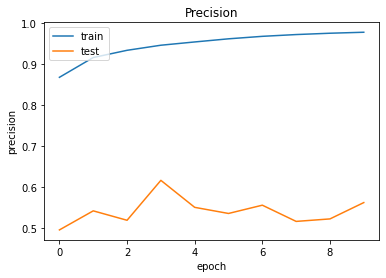

In [22]:
plt.plot(history.history['precision_m'])
plt.plot(history.history['val_precision_m'])
plt.title('Precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [23]:
test_eval = model.evaluate(test, verbose=1)
print('El modelo predice el ', test_eval[1]*100,'% de los datos')

  ...
    to  
  ['...']
142/142 [==============================] - 15s 103ms/step - loss: 0.7129 - accuracy: 0.5693 - f1_m: 0.5694 - precision_m: 0.5694 - recall_m: 0.5694
El modelo predice el  56.93495273590088 % de los datos


In [24]:
print("Las métricas del modelo son: ",model.metrics_names)

Las métricas del modelo son:  ['loss', 'accuracy', 'f1_m', 'precision_m', 'recall_m']


In [25]:
print("Obtenemos las métricas para test, con 50 epocas; ",test_eval)

Obtenemos las métricas para test, con 50 epocas;  [0.7129493574021568, 0.5693495, 0.5694274, 0.56942743, 0.56942743]
